In [38]:
import rioxarray as rxr
import xarray as xr
import numpy as np
from scipy import ndimage
from scipy import stats
import matplotlib.pyplot as plt

from slopes.__main__ import setup_wbt
from slopes.terrain.surface import elev_derivatives

In [37]:
wbt = setup_wbt("../working_dir/")

In [40]:
dem = rxr.open_rasterio("../data/input/dem.tif", masked=True).squeeze()
smoothed, slope, curvature = elev_derivatives(dem, wbt, .75)

In [64]:
sobel_h = ndimage.sobel(dem.data, 0)  # horizontal gradient
sobel_v = ndimage.sobel(dem.data, 1)  # vertical gradient
magnitude = np.sqrt(sobel_h**2 + sobel_v**2)

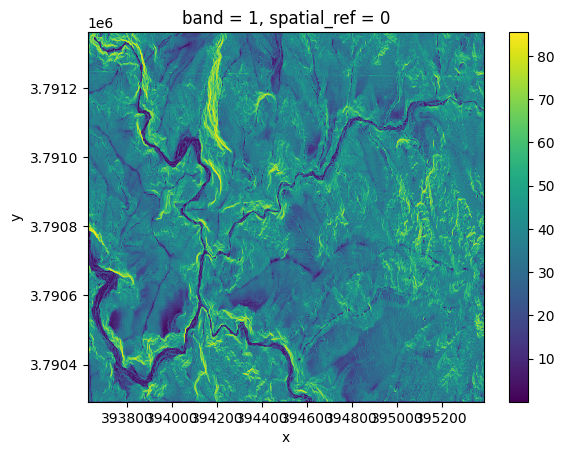

In [41]:
slope.plot()

In [47]:
def compute_neighborhood_std(slope_data: np.ndarray, window_size: int = 3) -> np.ndarray:
    """
    Compute standard deviation for each pixel's neighborhood using convolution.
    
    Parameters:
    -----------
    slope_data : np.ndarray
        Input slope array
    window_size : int
        Size of the moving window (must be odd)
        
    Returns:
    --------
    np.ndarray
        Array of standard deviations for each neighborhood
    """
    # Create kernel for mean calculation
    kernel = np.ones((window_size, window_size)) / (window_size * window_size)
    
    # Calculate mean using convolution
    mean = ndimage.convolve(slope_data, kernel, mode='reflect')
    
    # Calculate squared deviations
    squared_deviations = (slope_data - mean) ** 2
    
    # Calculate variance using convolution
    variance = ndimage.convolve(squared_deviations, kernel, mode='reflect')
    
    # Calculate standard deviation
    std = np.sqrt(variance)
    
    return std, std/mean

In [60]:
std, sm = compute_neighborhood_std(dem.data, 3)

In [61]:
test = dem.copy()
test.data = sm
test.rio.to_raster("sm_data_window.tif")

In [65]:
test = dem.copy()
test.data = magnitude
test.rio.to_raster('sobel.tif')

In [66]:
slope.rio.to_raster('slope.tif')

In [67]:
curvature.rio.to_raster('curvature.tif')